# Webinar 14: Sprint 4: Análisis de multiples datasets

Este notebook recrea (de forma simplificada) el proyecto del Sprint‑4 usando **datos sintéticos** generados en memoria. Cada apartado muestra el ejercicio, la solución paso a paso y una explicación breve.

## Objetivos
- Realizar un EDA a un dataset.
- Graficas de complejidad facil usando groupby
- Union de multiples dataframes usando el método `merge`

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
np.random.seed(42)

## 1. Generación de datos sintéticos

A continuación se generan tablas que imitan la estructura de `orders`, `order_products`, `products`, `departments` y `aisles` del conjunto *Instacart* original.

In [ ]:

# ----- Parámetros básicos -----
n_users = 5000
n_orders = 50000
n_products = 200
n_departments = 10
n_aisles = 20

# Departamentos y pasillos ficticios
departments = pd.DataFrame({
    "department_id": range(1, n_departments+1),
    "department": [f"Dept_{i}" for i in range(1, n_departments+1)]
})

aisles = pd.DataFrame({
    "aisle_id": range(1, n_aisles+1),
    "aisle": [f"Aisle_{i}" for i in range(1, n_aisles+1)]
})

# Productos
products = pd.DataFrame({
    "product_id": range(1, n_products+1),
    "product_name": [f"Product_{i}" for i in range(1, n_products+1)],
    "aisle_id": np.random.choice(aisles["aisle_id"], n_products),
    "department_id": np.random.choice(departments["department_id"], n_products)
})

# Órdenes
orders = pd.DataFrame({
    "order_id": range(1, n_orders+1),
    "user_id": np.random.choice(range(1, n_users+1), n_orders),
    "order_number": np.random.randint(1, 101, n_orders),
    "order_dow": np.random.randint(0, 7, n_orders),
    "order_hour_of_day": np.random.randint(0, 24, n_orders),
    "days_since_prior_order": np.random.choice([np.nan]+list(range(1, 31)), n_orders, p=[0.05]+[0.95/30]*30)
})

# order_products: para cada order_id añadir 1‑15 productos
rows=[]
for oid in orders["order_id"]:
    n_items=np.random.randint(1,16)
    prods=np.random.choice(products["product_id"], n_items)
    for pos, pid in enumerate(prods, start=1):
        rows.append({
            "order_id": oid,
            "product_id": pid,
            "add_to_cart_order": pos,
            "reordered": np.random.binomial(1, 0.4)  # 40 % prob.
        })
order_products = pd.DataFrame(rows)


## Vista rápida de las tablas
orders.head(), order_products.head(), products.head()

In [ ]:
orders.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,1680,42,5,19,25.0
1,2,3507,90,3,20,6.0
2,3,2745,32,3,13,15.0
3,4,3357,2,0,12,17.0
4,5,4046,8,1,12,3.0


In [ ]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,132,1,1
1,1,14,2,0
2,1,191,3,0
3,1,96,4,0
4,1,187,5,0


In [ ]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Product_1,7,10
1,2,Product_2,20,3
2,3,Product_3,15,3
3,4,Product_4,11,4
4,5,Product_5,8,7


## 2. [A] Fácil

Realicemos **tres** ejercicios introductorios.

### A1. Verificar rangos de `order_hour_of_day` (0‑23) y `order_dow` (0‑6)

#### ¿Qué queremos hacer?
Verificar que los valores de las columnas `order_hour_of_day` y `order_dow` estén dentro de los rangos válidos (0‑23 y 0‑6, respectivamente). Esto nos asegura que los datos sintéticos no contienen valores atípicos fuera del rango horario y semanal.

**Pista 💡:** Utiliza métodos como `.between()` o evalúa `min()` y `max()` para detectar si hay valores fuera de rango.

<Axes: xlabel='order_dow'>

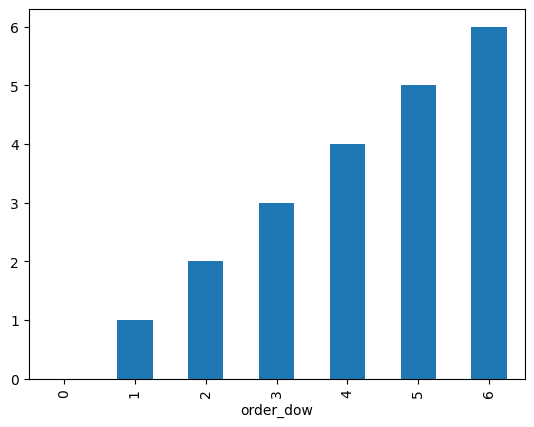

In [ ]:
orders.groupby('order_dow')['order_dow'].mean().plot(kind='bar')

In [ ]:
sorted(orders['order_hour_of_day'].unique())

[np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(11),
 np.int64(12),
 np.int64(13),
 np.int64(14),
 np.int64(15),
 np.int64(16),
 np.int64(17),
 np.int64(18),
 np.int64(19),
 np.int64(20),
 np.int64(21),
 np.int64(22),
 np.int64(23)]

In [ ]:
sorted(orders['order_dow'].unique())

[np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6)]

In [ ]:
orders['order_hour_of_day'].max()

23

In [ ]:

hour_ok = orders["order_hour_of_day"].between(0,23).all()
dow_ok = orders["order_dow"].between(0,6).all()
print(f"order_hour_of_day válido 0‑23 → {hour_ok}")
print(f"order_dow válido 0‑6 → {dow_ok}")


order_hour_of_day válido 0‑23 → True
order_dow válido 0‑6 → True


#### Explicación paso a paso
Comprobamos los valores mínimos y máximos de cada columna: si ambos límites caen en los rangos esperados, concluimos que no hay valores inválidos. Es una forma rápida y vectorizada sin necesidad de recorrer fila a fila.

### A2. Número de órdenes por hora del día

#### ¿Qué queremos hacer?
Calcular cuántas órdenes se realizan en cada hora del día para identificar las franjas horarias con mayor actividad de compra.

**Pista 💡:** Agrupa por `order_hour_of_day` y usa `.size()` para contar las filas en cada grupo; luego ordénalo de forma descendente.

In [ ]:
a2 = orders.groupby('order_hour_of_day')['order_id'].count()

<Axes: title={'center': 'xd'}, xlabel='xd', ylabel='xd'>

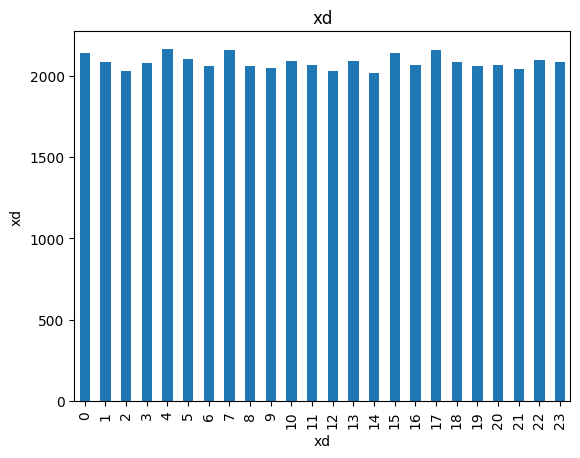

In [ ]:
a2.plot(kind='bar', title= 'xd', xlabel='xd', ylabel="xd")

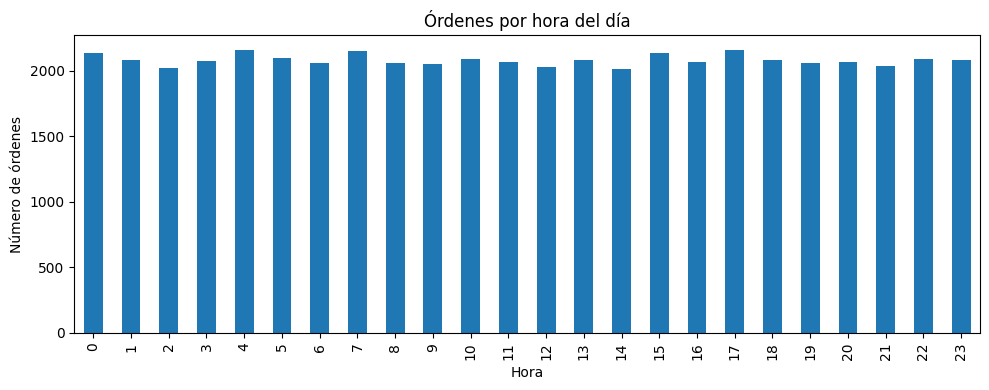

In [ ]:

orders_per_hour = orders.groupby("order_hour_of_day")["order_id"].nunique()
orders_per_hour.plot(kind="bar", figsize=(10,4))
plt.title("Órdenes por hora del día")
plt.xlabel("Hora")
plt.ylabel("Número de órdenes")
plt.tight_layout()
plt.show()


#### Explicación paso a paso
Agrupamos la tabla de pedidos por hora (`order_hour_of_day`) y contamos cuántos registros hay en cada grupo. Esto produce una serie con la frecuencia de órdenes por hora que luego se ordena de mayor a menor para resaltar los picos de actividad.

### A3. Órdenes por día de la semana

#### ¿Qué queremos hacer?
Determinar el volumen de pedidos de acuerdo al día de la semana para entender patrones semanales de compra.

**Pista 💡:** Agrupa por `order_dow` (día de la semana) y cuenta registros; puede ser útil un gráfico de barras para visualización.

<Axes: title={'center': 'xd'}, xlabel='xd', ylabel='xd'>

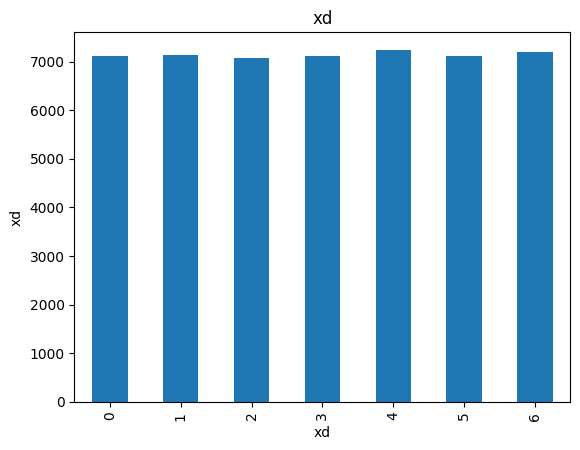

In [ ]:
a3 = orders.groupby('order_dow')['order_id'].count()
a3.plot(kind='bar', title= 'xd', xlabel='xd', ylabel="xd")

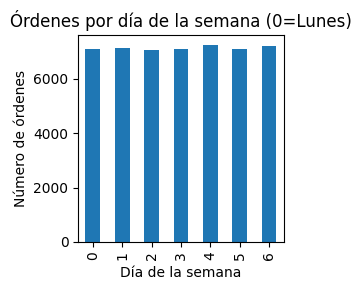

In [ ]:

orders_per_dow = orders.groupby("order_dow")["order_id"].nunique()
orders_per_dow.plot(kind="bar", figsize=(3,3))
plt.title("Órdenes por día de la semana (0=Lunes)")
plt.xlabel("Día de la semana")
plt.ylabel("Número de órdenes")
plt.tight_layout()
plt.show()


#### Explicación paso a paso
De forma análoga al ejercicio anterior, agrupamos por día de la semana (`order_dow`) y contamos las órdenes. El resultado revela qué días concentran mayor volumen de compras; visualizarlo ayuda a detectar tendencias semanales.

## 3. [B] Intermedio

Solo resolveremos **dos** ejercicios representativos.

### B1. Top‑10 productos más vendidos

#### ¿Qué queremos hacer?
Listar los 10 productos que han aparecido con mayor frecuencia en los pedidos para conocer los artículos más populares.

**Pista 💡:** Agrupa por `product_name` (o `product_id`) y cuenta apariciones; luego ordena y selecciona los primeros 10.

In [ ]:
b1 = order_products.groupby('product_id')['product_id'].count().rename("conteo").sort_values(ascending=False).head(10).reset_index()

In [ ]:
b1_2 = products.merge(b1, on=["product_id"], how='inner')
b1_2 = b1_2.sort_values(by='conteo', ascending=False)

<Axes: ylabel='product_name'>

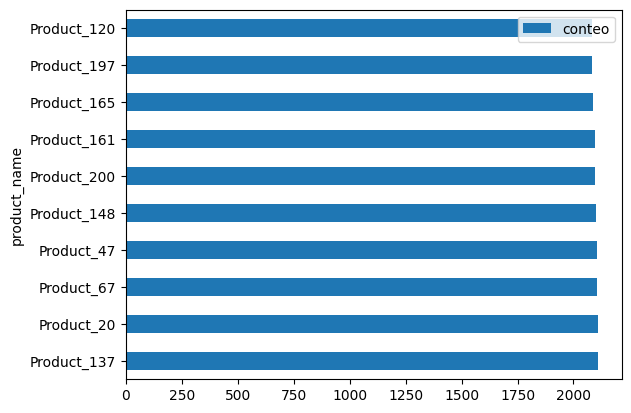

In [ ]:
b1_2.plot(kind='barh', x='product_name', y='conteo')

In [ ]:
dfull = order_products.merge(orders, on=['order_id'], how='outer')
dfull = dfull.merge(products, on=['product_id'], how='outer')
dfull.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,53,1,7,0,2775,7,2,16,18.0,Product_1,7,10
1,54,1,2,0,2897,15,1,11,21.0,Product_1,7,10
2,58,1,2,1,3070,48,6,4,5.0,Product_1,7,10
3,73,1,9,0,2505,60,4,17,22.0,Product_1,7,10
4,103,1,4,0,144,15,5,3,21.0,Product_1,7,10


In [ ]:
dfull.groupby('product_name')['reordered'].sum().sort_values(ascending=False).head(10)

#.plot(kind="bar")

,reordered
product_name,
Product_21,873
Product_47,873
Product_20,873
Product_137,870
Product_100,866
Product_139,863
Product_50,860
Product_163,859
Product_5,854


#### Explicación paso a paso
Unimos la tabla de detalles de producto con los pedidos y contamos cuántas veces aparece cada `product_id`. Ordenamos los resultados y mostramos los 10 primeros, lo que nos da una visión clara de los artículos más populares.

### B2. Ratio de reorden global

#### ¿Qué queremos hacer?
Calcular la proporción de productos que fueron reordenados (`reordered == 1`) respecto al total de productos pedidos.

**Pista 💡:** Suma la columna `reordered` y divídela por el número total de filas.

In [ ]:
print("La cantidad de reordenes es: ", (order_products['reordered'].sum()/len(order_products))*100, " %")

La cantidad de reordenes es:  39.97630863612559  %


#### Explicación paso a paso
Calculamos la tasa de reorden dividiendo la suma de la columna `reordered` (donde `1` indica que el artículo ya se había comprado antes) por el número total de filas. Esto nos da la fracción de veces que los clientes repiten la compra.

## 4. [C] Difícil

Seleccionamos **dos** retos analíticos avanzados.

### C1. Departamento con mayor *reorder ratio*

#### ¿Qué queremos hacer?
Identificar qué departamento tiene la tasa más alta de reorden (clientes que vuelven a comprar productos del mismo departamento).

**Pista 💡:** Fusiona las tablas `products` y `departments` para conocer el departamento de cada producto, agrupa por departamento y calcula la media de `reordered`.

In [ ]:
dfull.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,53,1,7,0,2775,7,2,16,18.0,Product_1,7,10
1,54,1,2,0,2897,15,1,11,21.0,Product_1,7,10
2,58,1,2,1,3070,48,6,4,5.0,Product_1,7,10
3,73,1,9,0,2505,60,4,17,22.0,Product_1,7,10
4,103,1,4,0,144,15,5,3,21.0,Product_1,7,10


<Axes: xlabel='product_id'>

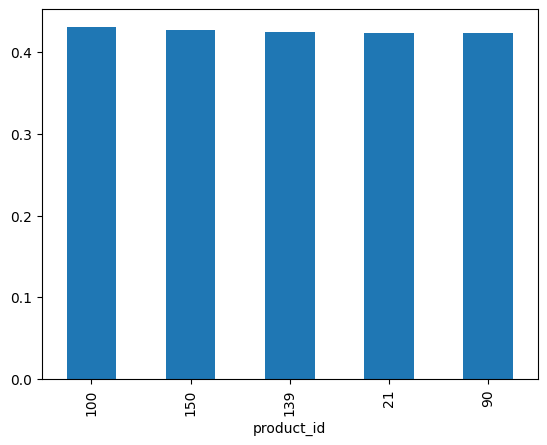

In [ ]:

# Enlazar tablas
merged = order_products.merge(products, on="product_id").merge(departments, on="department_id")

dept_reorder = merged.groupby("product_id")["reordered"].mean().sort_values(ascending=False)
dept_reorder.head(5).plot(kind='bar')


#### Explicación paso a paso
Después de relacionar productos y departamentos, agrupamos por departamento y calculamos la media de `reordered`. La media funciona porque `reordered` es 0/1, de modo que su promedio es la proporción de productos reordenados. El departamento con la media más alta es el 'ganador'.

### C2. Distribución de días entre pedidos por usuaria/o

#### ¿Qué queremos hacer?
Analizar la distribución de los días transcurridos entre pedidos consecutivos por usuaria/o para detectar la frecuencia de recompra.

**Pista 💡:** Dentro de cada usuario ordénalas por fecha y usa `.diff()` sobre `order_number` o `order_dow`; luego agrupa y visualiza con un histograma.

In [ ]:
c2 = orders.groupby("user_id")["days_since_prior_order"].mean()

<Axes: >

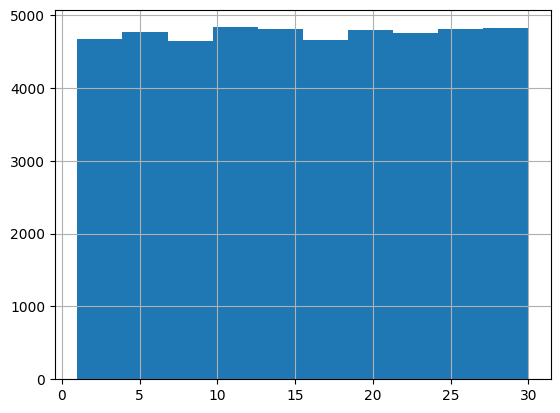

In [ ]:
orders["days_since_prior_order"].hist()

#### Explicación paso a paso
Ordenamos los pedidos de cada usuario por fecha y usamos `.diff()` para medir la distancia (en días) entre pedidos sucesivos. Graficamos la distribución resultante para ver si la mayoría de los intervalos es corta (usuarios frecuentes) o larga (usuarios ocasionales).

## 5. Conclusiones

Con datos totalmente sintéticos se replicó, de forma reducida, el análisis del Sprint‑4. El enfoque muestra cómo validar rangos de datos, explorar patrones temporales y evaluar métricas como el *reorder ratio* usando operaciones simples de `groupby`.